In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [ ]:
img_puzzle_path = '/content/hw5_puzzle_pieces.jpg'
img_ref_path = '/content/hw5_puzzle_reference.jpg'

img_puzzle = cv2.imread(img_puzzle_path)
img_ref = cv2.imread(img_ref_path)

img_puzzle = cv2.cvtColor(img_puzzle, cv2.COLOR_BGR2GRAY)
img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2GRAY)

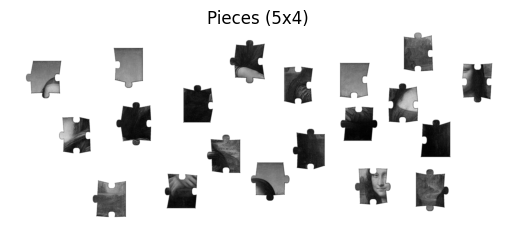

In [ ]:
plt.imshow(img_puzzle, cmap='gray')
plt.axis('off')
plt.title('Pieces (5x4)')

# Number of pierces = 20
# In horizontal axis -> 4
# In vertical axis -> 5

horizontal_num = 4
vertical_num = 5

## Creating separate image of every puzzle

In [ ]:
# Separate every puzzle individually

# Apply binary threshold
_, binary = cv2.threshold(img_puzzle, 250, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# List to store separated images
puzzles = []

# Loop through contours and extract each image
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    separated_image = img_puzzle[y:y+h, x:x+w]
    puzzles.append(separated_image)

print("Number of puzzles: ,", len(puzzles))

Number of puzzles: , 20


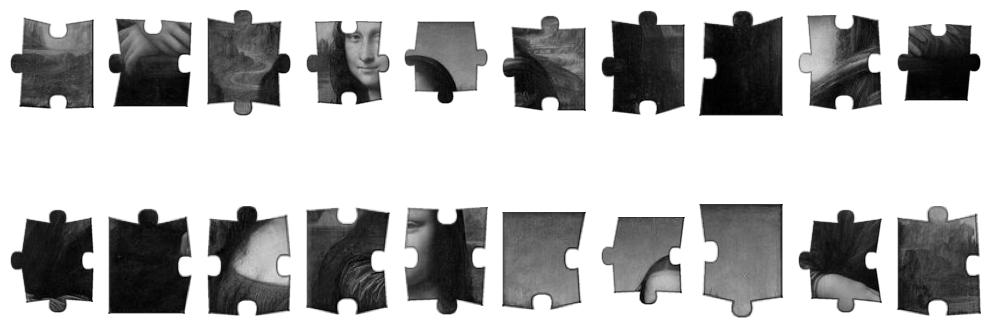

In [ ]:
### Plot the puzzles
fig, axes = plt.subplots(2, 10, figsize=(10, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, img in enumerate(puzzles):
  axes[i].imshow(img, cmap='gray')
  axes[i].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

## Separate monalisa into 20 squares

In [ ]:
height, width = img_ref.shape
rows, cols = 5, 4

cell_height = height // rows
cell_width = width // cols

cell_height, height

# Function to get the grid index for a given keypoint
def get_grid_index(x, y, cell_width, cell_height, cols):
    col_index = x // cell_width
    row_index = y // cell_height
    return row_index * cols + col_index

get_grid_index(500, 400, cell_height, cell_width, cols)

20

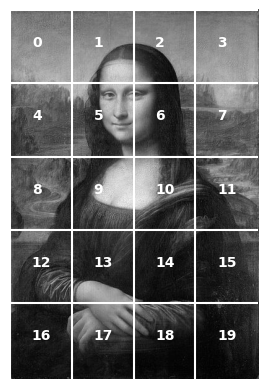

In [ ]:
# Plot the grid lines
plt.imshow(img_ref, cmap='gray')
plt.axis('off')

# Plot the grid lines
for i in range(rows):
  plt.axhline(y= i*cell_height, color='w', linestyle='-')
for j in range(cols):
  plt.axvline(x = j*cell_width, color='w', linestyle='-')

# Plot the index grid
for i in range(rows):
  for j in range(cols):
    # Calculate the left top points of current grid cell
    x = j * cell_width
    y = i * cell_height

    # num of row * cols + num of col
    index = i*cols + j

    # Add the index to center of each cell
    plt.text(x + cell_width//2 - 15, y + cell_height//2, str(index), color='w', fontweight='bold')

## Matching puzzle to an image

In [ ]:
puzzle_piece = puzzles[2]

In [ ]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints_ref, descriptors_ref = sift.detectAndCompute(img_ref, None)
keypoints_puzzle, descriptors_puzzle = sift.detectAndCompute(puzzle_piece, None)

# Use BFMatcher to find matches between descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors_ref, descriptors_puzzle)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

In [ ]:
# Print grid index for top matches

# create a list for each puzzle piece with matches
matched_indices = []

for match in matches[:5]:
  # get the keypoint coordinates
  kp_ref = keypoints_ref[match.queryIdx]
  x, y = int(kp_ref.pt[0]), int(kp_ref.pt[1])

  # get the keypoint index on the image
  index = get_grid_index(x, y, cell_width, cell_height, cols)

  # add the index to the list of matches for the piece
  matched_indices.append(index)

  print(f"Match at ({x}, {y}) in reference image is in grid index {index}")

# choose the most common match
most_common_cell = max(set(matched_indices), key=matched_indices.count)

print("Most common cell is:", most_common_cell)

Match at (54, 284) in reference image is in grid index 8
Match at (53, 292) in reference image is in grid index 8
Match at (68, 332) in reference image is in grid index 8
Match at (76, 301) in reference image is in grid index 8
Match at (40, 313) in reference image is in grid index 8
Most common cell is: 8


## Plot the matches with the reference image

In [ ]:

# Match the keypoints between the images
matched_image = cv2.drawMatches(img_ref, keypoints_ref, puzzle_piece, keypoints_puzzle,
                                matches[:5], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

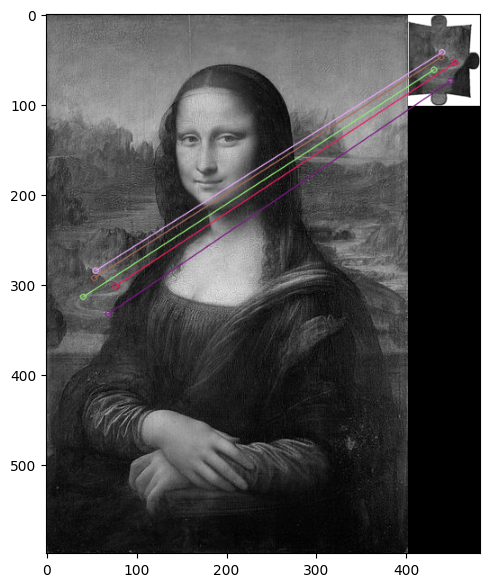

In [ ]:
plt.figure(figsize=(14, 7))
plt.imshow(matched_image, cmap='gray')

### Match every piece to Mona Lisa

In [ ]:
def match_puzzle_to_cell(puzzle_piece, is_verbose=False):
  """ Perform SIFT, match keypoints of two images
  pick the best matches, map them to the grid cells
  select the most common cell for every puzzle.
  Create a matching image between a puzzle and reference img """

  # Initialize SIFT detector
  sift = cv2.SIFT_create()

  # Detect keypoints and descriptors
  keypoints_ref, descriptors_ref = sift.detectAndCompute(img_ref, None)
  keypoints_puzzle, descriptors_puzzle = sift.detectAndCompute(puzzle_piece, None)

  # Use BFMatcher to find matches between descriptors
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  matches = bf.match(descriptors_ref, descriptors_puzzle)

  # Sort matches by distance (best matches first)
  matches = sorted(matches, key=lambda x: x.distance)

  # Print grid index for top matches

  # create a list for each puzzle piece with matches
  matched_indices = []

  for match in matches[:5]:
    # get the keypoint coordinates
    kp_ref = keypoints_ref[match.queryIdx]
    x, y = int(kp_ref.pt[0]), int(kp_ref.pt[1])

    # get the keypoint index on the image
    index = get_grid_index(x, y, cell_width, cell_height, cols)

    # add the index to the list of matches for the piece
    matched_indices.append(index)

    if is_verbose:
      print(f"Match at ({x}, {y}) in reference image is in grid index {index}")

  # choose the most common match
  most_common_cell = max(set(matched_indices), key=matched_indices.count)

  # Create a matching_image
  matched_image = cv2.drawMatches(img_ref, keypoints_ref, puzzle_piece, keypoints_puzzle,
                                  matches[:1], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

  return most_common_cell, matched_image

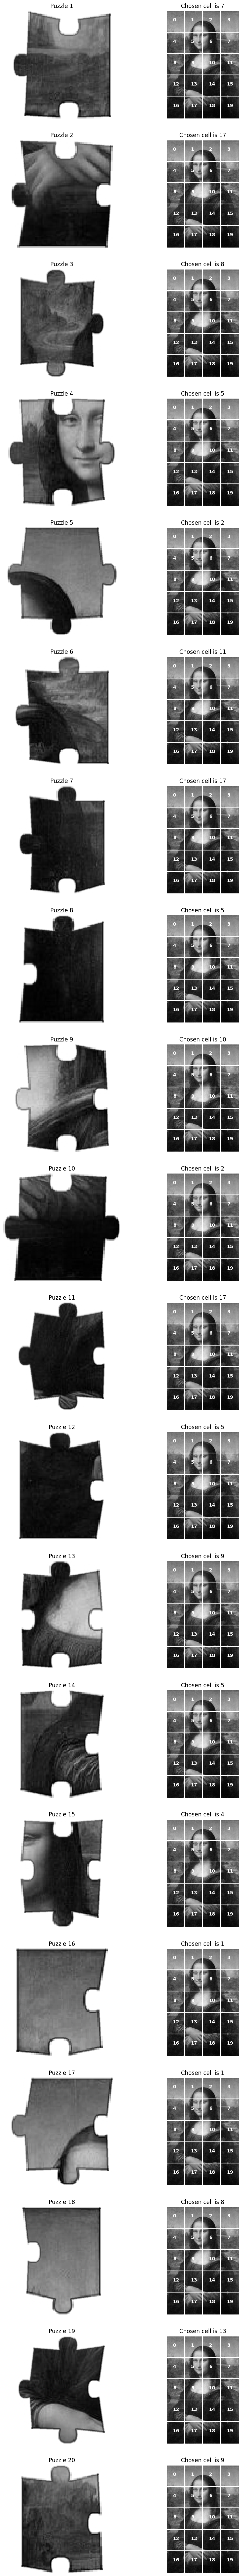

In [ ]:
import matplotlib.pyplot as plt

### Plot the puzzles with the chosen cell
fig, axes = plt.subplots(20, 2, figsize=(10, 100))  # 20 rows, 2 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, puzzle in enumerate(puzzles):

    # Choose a cell and a matching image
    cell, matched_image = match_puzzle_to_cell(puzzle)

    # Plot the puzzle
    axes[2*i].imshow(puzzle, cmap='gray')
    axes[2*i].axis('off')  # Hide the axis
    axes[2*i].set_title(f'Puzzle {i+1}')

    #### Plot the grid image
    # Plot the grid lines
    axes[2*i + 1].imshow(img_ref, cmap='gray')
    axes[2*i + 1].axis('off')

    # Plot the grid lines
    for row in range(rows):
        axes[2*i + 1].axhline(y=row*cell_height, color='w', linestyle='-')
    for col in range(cols):
        axes[2*i + 1].axvline(x=col*cell_width, color='w', linestyle='-')

    # Plot the index grid
    for row in range(rows):
        for col in range(cols):
            # Calculate the left top points of current grid cell
            x = col * cell_width
            y = row * cell_height

            # num of row * cols + num of col
            index = row*cols + col

            # Add the index to center of each cell
            axes[2*i + 1].text(x + cell_width//2 - 15, y + cell_height//2, str(index), color='w', fontweight='bold')

    #### PLOT
    axes[2*i + 1].axis('off')  # Hide the axis
    axes[2*i + 1].set_title(f'Chosen cell is {cell}')

plt.show()

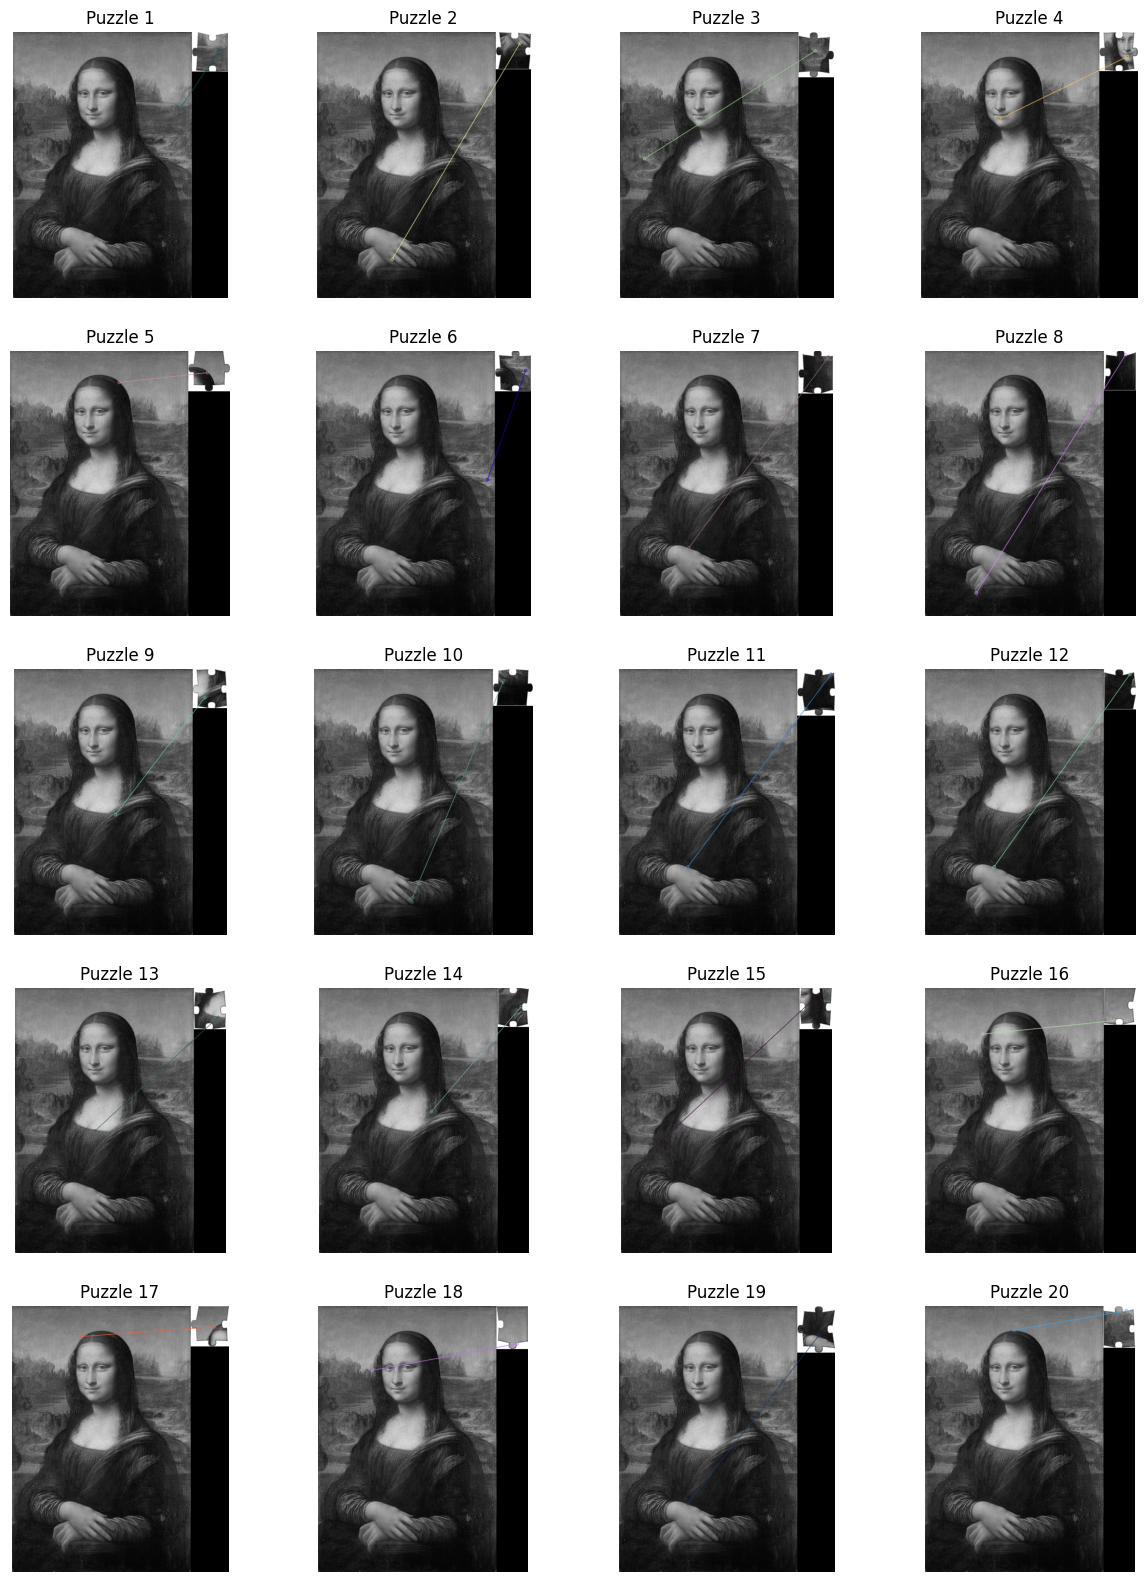

In [ ]:
### Here plot the matched images
### Plot the puzzles with the chosen cell
fig, axes = plt.subplots(5, 4, figsize=(15, 20))  # 20 rows, 2 columns
plt.title("Image matching visualization")

# Flatten the axes array for easy iteration
axes = axes.flatten()


for i, puzzle in enumerate(puzzles):

  # Choose a cell and a matching image
  cell, matched_image = match_puzzle_to_cell(puzzle)

  # Plot the matched_image
  axes[i].imshow(matched_image, cmap='gray')
  axes[i].axis('off')  # Hide the axis
  axes[i].set_title(f'Puzzle {i+1}')
